# Initialization

## Required function, Imports

In [42]:
import filter_inversion as fi
import predistortion_rec as pdr
import fixed_exam as fe
import numpy as np
import pickle
import matplotlib.pyplot as plt
import csv
import sys
def voltage_time_figure_plot(X1, Y1, color_code , label_set, name):
    # Create figure
    figure1 = plt.figure(name)
    
    # Create axes
    axes1 = figure1.add_subplot(1, 1, 1)
    i=0
    for case in Y1:
        # Create plot
        axes1.plot(X1, case, linewidth=2, color=color_code[i], label = label_set[i])
        i+=1
    
    # Set ylabel
    axes1.set_ylabel('Voltage (mV)', fontsize=16.5)
    
    # Set xlabel
    axes1.set_xlabel('Time (us)', fontsize=16.5)
    
    # Set title
    axes1.set_title(name, fontsize=16.5)
    axes1.legend()
    
    # Set x-axis limit
    # axes1.set_xlim([0, 0.000001])
    
    # Uncomment the following line to set y-axis limit
    # axes1.set_ylim([-60, 60])
    
    # Uncomment the following line to set z-axis limit
    # axes1.set_zlim([-1, 1])
    
    axes1.grid(True)
    axes1.set_axisbelow(True)
    axes1.tick_params(labelsize=15)
    
    # Show the plot
    plt.show()

def set_mean(input_array):
    return np.mean(input_array, axis=0)
def set_offset(input_array, adjust):
    return np.array(input_array) - input_array[0] * adjust
def set_gain(input_array, adjust):
    gain = np.max(input_array[1]) * adjust
    return np.array(input_array[1]) / gain

def read_filter_coef_csv():
    IIR_coef = []
    with open("IIR.csv") as csvfile:
        for row in csv.reader(csvfile):
            for coef in row:
                IIR_coef.append(float(coef))
    return IIR_coef

def set_gain_tail(waveform, time_point):
    time_point_index = np.where(np.array(waveform[0]) > time_point)[0][0]
    gain = np.abs(waveform[1][time_point_index])
    print("gain = {}".format(gain))
    print("waveform[1][time_point_index] = {}".format(np.array(waveform[1])[time_point_index]))
    print("np.array(waveform[1]) / gain = {}".format(np.array(waveform[1])[time_point_index] / gain))
    return np.array(waveform[1]) / gain

def moving_agerage(waveform,window_size ):
    i = 0
    # Initialize an empty list to store moving averages
    moving_averages = []
    arr = np.array(waveform[1])
    # Loop through the array t o
    while i < len(arr) - window_size + 1:
    
        # Calculate the average of current window
        window_average = np.sum(arr[
        i:i+window_size]) / window_size
        
        # Store the average of current
        # window in moving average list
        moving_averages.append(window_average)
        
        # Shift window to right by one position
        i += 1
    waveform[0] = np.array(waveform[0])[0 : len(arr) - window_size+1]
    waveform[1] = moving_averages
    
    return waveform

def load_waveform(file_name):
    X,Y =  pickle.load(open(file_name,"rb"))
    
    waveform = [X[0],set_mean(Y)]
    waveform[0] = waveform[0]*10**(6)
    waveform[1] = set_offset(waveform[1], 1)
    waveform[1] = set_gain(waveform, 1)
    
    %matplotlib qt
    voltage_time_figure_plot(waveform[0], [waveform[1]], ['green'], ['The original waveform'], "name")
    
    return waveform

def cal_smooth_param(waveform):
    start_time_exam = 40.027
    end_time_exam = 109.9943
    windows_size = 100
    param = [start_time_exam, end_time_exam, windows_size]
    smooth_param = fe.smooth_param(waveform, param)
    print("Smooth parameter = {}".format(smooth_param))
    return smooth_param

def down_sampling(waveform, target_sampling_rate):
    X, Y = waveform
    old_sampling_rate = np.rint(1/(X[1]-X[0])) * 10**(6) + 1
    down_sampling_step = int(old_sampling_rate / target_sampling_rate)
    print("down_sampling_step = {}".format(down_sampling_step))
    X_down, Y_down = [], []
    i = 0
    while down_sampling_step * i < len(X):
        X_down.append(X[down_sampling_step * i])
        Y_down.append(Y[down_sampling_step * i])
        i+=1
    
    return [X_down, Y_down]

# IIR fitting & Inverse filtering

## First Fitting & Filtering

### Load full waveform

In [3]:
file_name = "2nd_BareAWG_10rep_80G_80kpts_70us_LineCase2_QZ.pkl"
waveform = load_waveform("E:/OP/Experiments/0616_2023_pred/DATA/QZ/copper_line/"+file_name)

In [4]:
"""
Select the start_time and end_time of you waveform that will be sent to the fitting process

Use the get_waveform_segment() to slice out your waveform to get the data segment
"""
start_time = 44.82
end_time = 109.98
waveform_segment = fi.get_waveform_segment(start_time, end_time, np.copy(waveform))
voltage_time_figure_plot(waveform_segment[0], [waveform_segment[1]], ['blue'], ['The selected waveform segment'], "name")

smooth_param = cal_smooth_param(waveform)

Smooth parameter = 0.6069187046466017


In [12]:
"""
type: string
    'highpass': high-pass model fitting;
    'lowpass': low-pass model fitting;
    'line': linear model fitting;
    'skin': skin effect model fitting;
"""
type = 'highpass'
fs = 1 / (waveform[0][1] - waveform[0][0])
time_offset = start_time # 40
amp_offset = 0.99422
coef_B = 1- amp_offset
coef_tau = 1e-2
param = [type, fs, coef_B, coef_tau, time_offset, amp_offset]

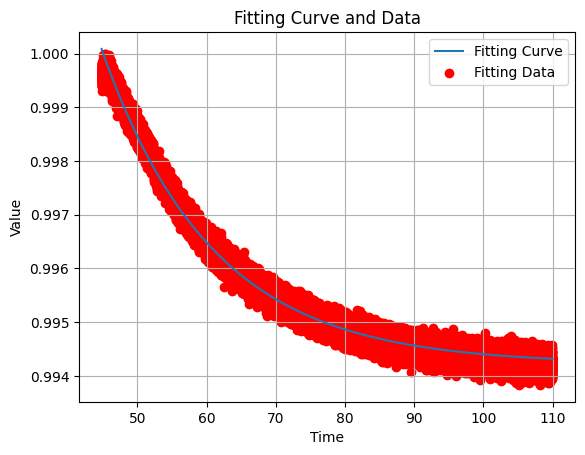

[5.86643905e-03 1.59271519e+01]
Smooth parameter = 0.20109539544746133


In [8]:
%matplotlib inline
waveform_pred_1st = fi.predistor(np.copy(waveform), np.copy(waveform_segment), param)
# waveform_record.append(waveform_pred_1st)

_ = cal_smooth_param(waveform_pred_1st)

%matplotlib qt
voltage_time_figure_plot(waveform_pred_1st[0], [waveform_pred_1st[1]], ['green'], ['Predistorted waveform'],"name")

IIR_coef = read_filter_coef_csv()
# pickle.dump(IIR_coef , open("E:/OP/Experiments/0616_2023_pred/DATA/QZ/copper_line/IIR/IIR_1st_atp2.pkl" , "wb"))

In [15]:
tau_fit , A_fit = [5.86643905e-03, 1.59271519e+01]
t_test=40
amp_offset + A_fit*np.exp(-(t_test-time_offset)/tau_fit)

C:\Users\BAQIS103\AppData\Local\Temp\ipykernel_3228\2627297183.py:3: RuntimeWarning: overflow encountered in exp
  amp_offset + A_fit*np.exp(-(t_test-time_offset)/tau_fit)


inf

In [20]:
# [a0, b0, a1, b1]
pickle.load(open("E:/OP/Experiments/0616_2023_pred/DATA/QZ/copper_line/IIR/IIR_1st_atp2.pkl", "rb"))

[1.0, 0.9998333170852227, 0.9999444865505324, -0.9997773107802713]

In [21]:
np.array(pickle.load(open("E:/OP/Experiments/0616_2023_pred/DATA/QZ/copper_line/IIR/IIR_1st_atp2.pkl", "rb")))  - np.array([1,1,1,-1])

array([ 0.00000000e+00, -1.66682915e-04, -5.55134495e-05,  2.22689220e-04])

## Second Fitting & Filtering

### Load waveform

In [25]:
file_name = "spMin_1st_predAWG_pm2us_50SweepSteps_b0a1.pkl"
waveform = load_waveform("E:/OP/Experiments/0616_2023_pred/DATA/QZ/copper_line/"+file_name)

In [33]:
"""
Select the start_time and end_time of you waveform that will be sent to the fitting process

Use the get_waveform_segment() to slice out your waveform to get the data segment
"""
start_time = 40.054
end_time = 40.31
waveform_segment = fi.get_waveform_segment(start_time, end_time, np.copy(waveform))
voltage_time_figure_plot(waveform_segment[0], waveform_segment[1], 'blue', 'The selected waveform segment')

In [62]:
"""
type: string
    'highpass': high-pass model fitting;
    'lowpass': low-pass model fitting;
    'line': linear model fitting;
    'skin': skin effect model fitting;
"""
type = 'highpass'
fs = 1 / (waveform[0][1] - waveform[0][0])
time_offset = start_time
amp_offset = 0.9745
coef_B = 1.3- amp_offset
coef_tau = 1e-4
param = [type, fs, coef_B, coef_tau, time_offset, amp_offset]

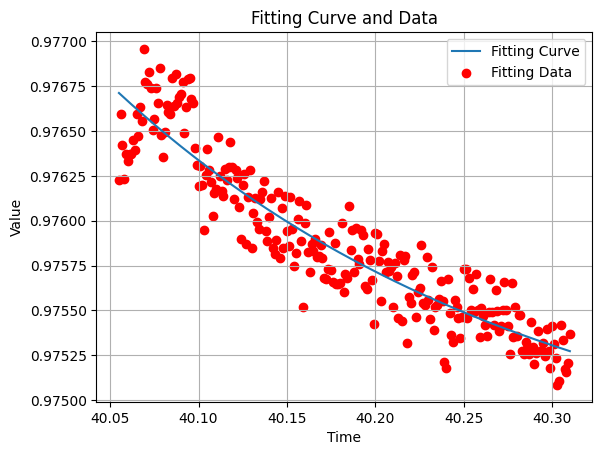

In [63]:
%matplotlib inline
waveform_pred_2nd = fi.predistor(np.copy(waveform), np.copy(waveform_segment), param)
# waveform_record.append(waveform_pred_2nd)

%matplotlib qt
voltage_time_figure_plot(waveform_pred_2nd[0], waveform_pred_2nd[1], 'green', 'Predistorted waveform')

IIR_coef = read_filter_coef_csv()
pickle.dump(IIR_coef , open("E:/OP/Experiments/0616_2023_pred/DATA/QZ/copper_line/IIR/IIR_2nd.pkl" , "wb"))

In [40]:
# [a0, b0, a1, b1]
pickle.load(open("E:/OP/Experiments/0616_2023_pred/DATA/QZ/copper_line/IIR/IIR_2nd.pkl", "rb"))

[1.0, 1.0042760379008517, 0.999940238147385, -1.0042153474848723]

In [41]:
np.array(pickle.load(open("E:/OP/Experiments/0616_2023_pred/DATA/QZ/copper_line/IIR/IIR_2nd.pkl", "rb")))  - np.array([1,1,1,-1])

array([ 0.00000000e+00,  4.27603790e-03, -5.97618526e-05, -4.21534748e-03])

## Third Fitting & Filtering

### Load waveform

In [2]:
file_name = "FIR_1stIIR_PredAWG_10rep_80G_80kpts_70us_LineCase2_QZ.pkl"
waveform = load_waveform("E:/OP/Experiments/0616_2023_pred/DATA/QZ/copper_line/"+file_name)

In [5]:
"""
Select the start_time and end_time of you waveform that will be sent to the fitting process

Use the get_waveform_segment() to slice out your waveform to get the data segment
"""
start_time = 40.017
end_time = 109.976
waveform_segment = fi.get_waveform_segment(start_time, end_time, np.copy(waveform))

%matplotlib qt
voltage_time_figure_plot(waveform_segment[0], [waveform_segment[1]], ['blue'], ['The selected waveform segment'], "name")

In [18]:
"""
type: string
    'highpass': high-pass model fitting;
    'lowpass': low-pass model fitting;
    'line': linear model fitting;
    'skin': skin effect model fitting;
"""
type = 'lowpass'
fs = 1 / (waveform[0][1] - waveform[0][0])
time_offset = start_time
amp_offset = 0.995
coef_B = - amp_offset
coef_tau = 1e-2
param = [type, fs, coef_B, coef_tau, time_offset, amp_offset]

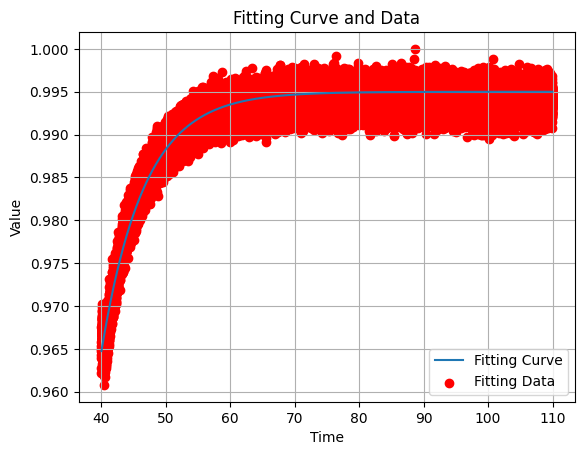

[-0.03025298  6.63052046]


In [19]:
%matplotlib inline
waveform_pred_3rd = fi.predistor(np.copy(waveform), np.copy(waveform_segment), param)
# waveform_record.append(waveform_pred_1)

%matplotlib qt
voltage_time_figure_plot(waveform_pred_3rd[0], [waveform_pred_3rd[1]], ['green'], ['Predistorted waveform'], "predistorted result")

IIR_coef = read_filter_coef_csv()
pickle.dump(IIR_coef , open("E:/OP/Experiments/0616_2023_pred/DATA/QZ/copper_line/IIR/IIR_3rd.pkl" , "wb"))

In [20]:
# [a0, b0, a1, b1]
pickle.load(open("E:/OP/Experiments/0616_2023_pred/DATA/QZ/copper_line/IIR/IIR_3rd.pkl", "rb"))

[1.0, 1.0365387091816738, 0.9998444649625162, -1.036382392561087]

In [21]:
np.array(pickle.load(open("E:/OP/Experiments/0616_2023_pred/DATA/QZ/copper_line/IIR/IIR_3rd.pkl", "rb")))  - np.array([1,1,1,-1])

array([ 0.        ,  0.03653871, -0.00015554, -0.03638239])

## Fourth Fitting & Filtering

> IIR filtering, Highpass. Applying to the front part of the waveform, time interval: $[0, 500 ns]$

### Load waveform

In [45]:
file_name = "2nd_BareAWG_10rep_80G_80kpts_70us_LineCase2_QZ.pkl"
waveform = load_waveform("E:/OP/Experiments/0616_2023_pred/DATA/QZ/copper_line/"+file_name)

In [46]:
"""
Select the start_time and end_time of you waveform that will be sent to the fitting process

Use the get_waveform_segment() to slice out your waveform to get the data segment
"""
start_time = 40.0696
end_time = 40.3
waveform_segment = fi.get_waveform_segment(start_time, end_time, np.copy(waveform))

%matplotlib qt
voltage_time_figure_plot(waveform_segment[0], [waveform_segment[1]], ['blue'], ['segment'],'The selected waveform segment')

In [47]:
"""
type: string
    'highpass': high-pass model fitting;
    'lowpass': low-pass model fitting;
    'line': linear model fitting;
    'skin': skin effect model fitting;
"""
type = 'highpass'
fs = 1 / (waveform[0][1] - waveform[0][0])
time_offset = start_time
amp_offset = 0.99
coef_B = 0.997696-amp_offset
coef_tau = 1e-2
param = [type, fs, coef_B, coef_tau, time_offset, amp_offset]

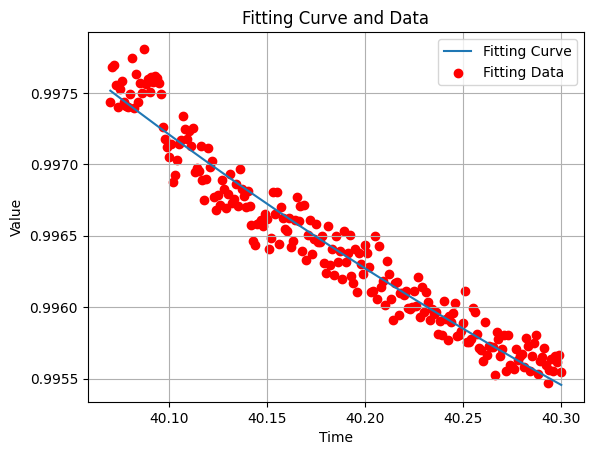

[0.00751906 0.71854791]


In [48]:
%matplotlib inline
waveform_pred_IIR_shortRange = fi.predistor(np.copy(waveform), np.copy(waveform_segment), param)
# waveform_record.append(waveform_pred_1)

%matplotlib qt
voltage_time_figure_plot(waveform_pred_IIR_shortRange[0], [waveform_pred_IIR_shortRange[1]], ['green'], ['IIR_highpass_shortRnage'], 'Predistorted waveform')

IIR_coef = read_filter_coef_csv()
pickle.dump(IIR_coef , open("E:/OP/Experiments/0616_2023_pred/DATA/QZ/copper_line/IIR/IIR_4th.pkl" , "wb"))

In [49]:
# [a0, b0, a1, b1]
pickle.load(open("E:/OP/Experiments/0616_2023_pred/DATA/QZ/copper_line/IIR/IIR_4th.pkl", "rb"))

[1.0, 1.0024923645196684, 0.9986197478255687, -1.0010981704040811]

In [50]:
np.array(pickle.load(open("E:/OP/Experiments/0616_2023_pred/DATA/QZ/copper_line/IIR/IIR_4th.pkl", "rb")))  - np.array([1,1,1,-1])

array([ 0.        ,  0.00249236, -0.00138025, -0.00109817])

## Fifth Fitting & Filtering

### Load Waveform

In [38]:
file_name = "2nd_IIR_PredAWG_10rep_80G_80kpts_70us_LineCase2_QZ.pkl"
waveform = load_waveform("E:/OP/Experiments/0616_2023_pred/DATA/QZ/copper_line/"+file_name)

In [39]:
"""
Select the start_time and end_time of you waveform that will be sent to the fitting process

Use the get_waveform_segment() to slice out your waveform to get the data segment
"""
start_time = 40.82
end_time = 110.786
waveform_segment = fi.get_waveform_segment(start_time, end_time, np.copy(waveform))

%matplotlib qt
voltage_time_figure_plot(waveform_segment[0], [waveform_segment[1]], ['blue'], ['segment'],'The selected waveform segment')

In [45]:
"""
type: string
    'highpass': high-pass model fitting;
    'lowpass': low-pass model fitting;
    'line': linear model fitting;
    'skin': skin effect model fitting;
"""
type = 'highpass'
fs = 1 / (waveform[0][1] - waveform[0][0])
print("Ts = {}".format(1/fs))
time_offset = start_time
amp_offset = 0.68012
coef_B = 1.02-amp_offset
coef_tau = 1e-3
param = [type, fs, coef_B, coef_tau, time_offset, amp_offset]

Ts = 0.0009999999999976694


In [41]:
%matplotlib qt
waveform_pred_IIR_shortRange_2nd = fi.predistor(np.copy(waveform), np.copy(waveform_segment), param)
# waveform_record.append(waveform_pred_1)

%matplotlib qt
voltage_time_figure_plot(waveform_pred_IIR_shortRange_2nd[0], [waveform_pred_IIR_shortRange_2nd[1]], ['green'], ['IIR_highpass_shortRnage'], 'Predistorted waveform')

IIR_coef = read_filter_coef_csv()
pickle.dump(IIR_coef , open("E:/OP/Experiments/0616_2023_pred/DATA/QZ/copper_line/IIR/IIR_5th.pkl" , "wb"))

[0.31928477 2.68454779]


In [32]:
# [a0, b0, a1, b1]
pickle.load(open("E:/OP/Experiments/0616_2023_pred/DATA/QZ/copper_line/IIR/IIR_5th.pkl", "rb"))

[1.0, 1.0006551131405372, 0.9997465350306606, -1.0002824363050677]

In [33]:
np.array(pickle.load(open("E:/OP/Experiments/0616_2023_pred/DATA/QZ/copper_line/IIR/IIR_5th.pkl", "rb")))  - np.array([1,1,1,-1])

array([ 0.        ,  0.00065511, -0.00025346, -0.00028244])

## 6th IIR filtering

In [46]:
file_name = "optimized_2nd_IIR_PredAWG_10rep_80G_80kpts_70us_LineCase2_QZ.pkl"
waveform = load_waveform("E:/OP/Experiments/0616_2023_pred/DATA/QZ/copper_line/"+file_name)

In [48]:
"""
Select the start_time and end_time of you waveform that will be sent to the fitting process

Use the get_waveform_segment() to slice out your waveform to get the data segment
"""
start_time = 40.833
end_time = 45.131
waveform_segment = fi.get_waveform_segment(start_time, end_time, np.copy(waveform))

%matplotlib qt
voltage_time_figure_plot(waveform_segment[0], [waveform_segment[1]], ['blue'], ['segment'],'The selected waveform segment')

In [63]:
"""
type: string
    'highpass': high-pass model fitting;
    'lowpass': low-pass model fitting;
    'line': linear model fitting;
    'skin': skin effect model fitting;
"""
type = 'highpass'
fs = 1 / (waveform[0][1] - waveform[0][0])
print("Ts = {}".format(1/fs))
time_offset = start_time
amp_offset = 0.99
coef_B = 1.2-amp_offset
coef_tau = 1e-3
param = [type, fs, coef_B, coef_tau, time_offset, amp_offset]

Ts = 0.0009999999999976694


In [64]:
%matplotlib qt
waveform_pred_IIR_6th= fi.predistor(np.copy(waveform), np.copy(waveform_segment), param)
# waveform_record.append(waveform_pred_1)

%matplotlib qt
voltage_time_figure_plot(waveform_pred_IIR_6th[0], [waveform_pred_IIR_6th[1]], ['green'], ['IIR_highpass'], 'Predistorted waveform')

IIR_coef = read_filter_coef_csv()
pickle.dump(IIR_coef , open("E:/OP/Experiments/0616_2023_pred/DATA/QZ/copper_line/IIR/IIR_6th.pkl" , "wb"))

[0.00457145 1.10870381]


In [ ]:
# [a0, b0, a1, b1]
pickle.load(open("E:/OP/Experiments/0616_2023_pred/DATA/QZ/copper_line/IIR/IIR_6th.pkl", "rb"))

In [ ]:
np.array(pickle.load(open("E:/OP/Experiments/0616_2023_pred/DATA/QZ/copper_line/IIR/IIR_6th.pkl", "rb")))  - np.array([1,1,1,-1])

## 7th IIR filtering

In [66]:
file_name = "optimized_1st_IIR_PredAWG_10rep_80G_80kpts_70us_LineCase2_QZ.pkl"
waveform = load_waveform("E:/OP/Experiments/0616_2023_pred/DATA/QZ/copper_line/"+file_name)

In [70]:
"""
Select the start_time and end_time of you waveform that will be sent to the fitting process

Use the get_waveform_segment() to slice out your waveform to get the data segment
"""
start_time = 40.83
end_time = 110.7
waveform_segment = fi.get_waveform_segment(start_time, end_time, np.copy(waveform))

%matplotlib qt
voltage_time_figure_plot(waveform_segment[0], [waveform_segment[1]], ['blue'], ['segment'],'The selected waveform segment')

In [71]:
"""
type: string
    'highpass': high-pass model fitting;
    'lowpass': low-pass model fitting;
    'line': linear model fitting;
    'skin': skin effect model fitting;
"""
type = 'highpass'
fs = 1 / (waveform[0][1] - waveform[0][0])
print("Ts = {}".format(1/fs))
time_offset = start_time
amp_offset = 0.9622
coef_B = 1-amp_offset
coef_tau = 1e-3
param = [type, fs, coef_B, coef_tau, time_offset, amp_offset]

Ts = 0.0009999999999976694


In [74]:
%matplotlib qt
waveform_pred_IIR_7th= fi.predistor(np.copy(waveform), np.copy(waveform_segment), param)
# waveform_record.append(waveform_pred_1)

%matplotlib qt
voltage_time_figure_plot(waveform_pred_IIR_7th[0], [waveform_pred_IIR_7th[1]], ['green'], ['IIR_highpass'], 'Predistorted waveform')

IIR_coef = read_filter_coef_csv()
pickle.dump(IIR_coef , open("E:/OP/Experiments/0616_2023_pred/DATA/QZ/copper_line/IIR/IIR_7th.pkl" , "wb"))

[0.03171516 6.59134172]


In [ ]:
# [a0, b0, a1, b1]
pickle.load(open("E:/OP/Experiments/0616_2023_pred/DATA/QZ/copper_line/IIR/IIR_7th.pkl", "rb"))

In [ ]:
np.array(pickle.load(open("E:/OP/Experiments/0616_2023_pred/DATA/QZ/copper_line/IIR/IIR_7th.pkl", "rb")))  - np.array([1,1,1,-1])

## 8th IIR filtering

In [98]:
file_name = "Diplexer_PredAWG_10rep_10G_10kpts_1us_LineCase2_QZ.pkl"
waveform = load_waveform("E:/OP/Experiments/0616_2023_pred/DATA/QZ/DC_block/"+file_name)

In [107]:
"""
Select the start_time and end_time of you waveform that will be sent to the fitting process

Use the get_waveform_segment() to slice out your waveform to get the data segment
"""
start_time = 0.5009
end_time = 0.52
waveform_segment = fi.get_waveform_segment(start_time, end_time, np.copy(waveform))
voltage_time_figure_plot(waveform_segment[0], [waveform_segment[1]], ['blue'], ['The selected waveform segment'],"name")

# smooth_param = cal_smooth_param(waveform)

In [120]:
"""
type: string
    'highpass': high-pass model fitting;
    'lowpass': low-pass model fitting;
    'line': linear model fitting;
    'skin': skin effect model fitting;
"""
type = 'lowpass'
fs = 1 / (waveform[0][1] - waveform[0][0])
print("Ts = {}".format(1/fs))
time_offset = start_time
amp_offset = 0.98
coef_B = -amp_offset
coef_tau = 1e-4
param = [type, fs, coef_B, coef_tau, time_offset, amp_offset]

Ts = 0.0001000000000000445


In [121]:
# """
# type: string
#     'highpass': high-pass model fitting;
#     'lowpass': low-pass model fitting;
#     'line': linear model fitting;
#     'skin': skin effect model fitting;
# """
# type = 'skin'
# fs = 1 / (waveform[0][1] - waveform[0][0])
# print("Ts = {}".format(1/fs))
# time_offset = start_time
# amp_offset = 0
# coef_B = 0.05
# coef_tau = None
# param = [type, fs, coef_B, coef_tau, time_offset, amp_offset]

In [122]:
%matplotlib qt
waveform_pred_IIR_7th= fi.predistor(np.copy(waveform), np.copy(waveform_segment), param)
# waveform_record.append(waveform_pred_1)

%matplotlib qt
voltage_time_figure_plot(waveform_pred_IIR_7th[0], [waveform_pred_IIR_7th[1]], ['green'], ['IIR_highpass'], 'Predistorted waveform')

IIR_coef = read_filter_coef_csv()
pickle.dump(IIR_coef , open("E:/OP/Experiments/0616_2023_pred/DATA/QZ/copper_line/IIR/IIR_7th.pkl" , "wb"))

[-1.20683225e+00  4.29849059e-04]


In [ ]:
# [a0, b0, a1, b1]
pickle.load(open("E:/OP/Experiments/0616_2023_pred/DATA/QZ/copper_line/IIR/IIR_7th.pkl", "rb"))

In [ ]:
np.array(pickle.load(open("E:/OP/Experiments/0616_2023_pred/DATA/QZ/copper_line/IIR/IIR_7th.pkl", "rb")))  - np.array([1,1,1,-1])

## 9th IIR filtering

In [165]:
file_name = "CuNiLine_LongRange_PredAWG_10rep_1G_80kpts_70us_LineCase2_QZ.pkl"
waveform = load_waveform("E:/OP/Experiments/0616_2023_pred/DATA/QZ/DC_block/"+file_name)

In [192]:
"""
Select the start_time and end_time of you waveform that will be sent to the fitting process

Use the get_waveform_segment() to slice out your waveform to get the data segment
"""
start_time = 40.02
end_time = 40.2
waveform_segment = fi.get_waveform_segment(start_time, end_time, np.copy(waveform))
voltage_time_figure_plot(waveform_segment[0], [waveform_segment[1]], ['blue'], ['The selected waveform segment'],"name")

# smooth_param = cal_smooth_param(waveform)

In [198]:
"""
type: string
    'highpass': high-pass model fitting;
    'lowpass': low-pass model fitting;
    'line': linear model fitting;
    'skin': skin effect model fitting;
"""
type = 'lowpass'
fs = 1 / (waveform[0][1] - waveform[0][0])
print("Ts = {}".format(1/fs))
time_offset = start_time
amp_offset = 0.99
coef_B = -amp_offset
coef_tau = 1e-4
param = [type, fs, coef_B, coef_tau, time_offset, amp_offset]

Ts = 0.0009999999999976694


In [199]:
%matplotlib qt
waveform_pred_IIR_7th= fi.predistor(np.copy(waveform), np.copy(waveform_segment), param)
# waveform_record.append(waveform_pred_1)

%matplotlib qt
voltage_time_figure_plot(waveform_pred_IIR_7th[0], [waveform_pred_IIR_7th[1]], ['green'], ['IIR_highpass'], 'Predistorted waveform')

IIR_coef = read_filter_coef_csv()
pickle.dump(IIR_coef , open("E:/OP/Experiments/0616_2023_pred/DATA/QZ/copper_line/IIR/IIR_7th.pkl" , "wb"))

[-0.05086811  0.02238514]


## 10th IIR

In [230]:
file_name = "3rd_IIR_PredAWG_10rep_10G_10kpts_1us_LineCase2_QZ.pkl"
waveform = load_waveform("E:/OP/Experiments/0616_2023_pred/DATA/QZ/copper_line/"+file_name)

In [279]:
"""
Select the start_time and end_time of you waveform that will be sent to the fitting process

Use the get_waveform_segment() to slice out your waveform to get the data segment
"""
start_time = 0.5089
end_time = start_time + 0.1
waveform_segment = fi.get_waveform_segment(start_time, end_time, np.copy(waveform))
voltage_time_figure_plot(waveform_segment[0], [waveform_segment[1]], ['blue'], ['The selected waveform segment'],"name")

# smooth_param = cal_smooth_param(waveform)

In [294]:
"""
type: string
    'highpass': high-pass model fitting;
    'lowpass': low-pass model fitting;
    'line': linear model fitting;
    'skin': skin effect model fitting;
"""
type = 'skin'
fs = 1 / (waveform[0][1] - waveform[0][0])
print("Ts = {}".format(1/fs))
time_offset = start_time+0.00005
amp_offset = 0
coef_B = 0.0015
coef_tau = None
param = [type, fs, coef_B, coef_tau, time_offset, amp_offset]

Ts = 0.0001000000000000445


In [295]:
%matplotlib qt
waveform_pred_IIR_7th= fi.predistor(np.copy(waveform), np.copy(waveform_segment), param)
# waveform_record.append(waveform_pred_1)

%matplotlib qt
voltage_time_figure_plot(waveform_pred_IIR_7th[0], [waveform_pred_IIR_7th[1]], ['green'], ['IIR_highpass'], 'Predistorted waveform')

IIR_coef = read_filter_coef_csv()
pickle.dump(IIR_coef , open("E:/OP/Experiments/0616_2023_pred/DATA/QZ/copper_line/IIR/IIR_7th.pkl" , "wb"))

[0.0015]


UnboundLocalError: cannot access local variable 'b0' where it is not associated with a value

# Collection of plot

In [8]:
# X_1stPred, Y_1stPred =  pickle.load(open("E:/OP/Experiments/0609_predistortion/DATA/test/test/retest_500smooth_BareAWG_1stPred.pkl","rb"))
X_2ndPred, Y_2ndPred =  pickle.load(open("E:/OP/Experiments/0609_predistortion/DATA/test/test/retest_500smooth_BareAWG_2ndPred.pkl","rb"))
# X_bare_new, Y_bare_new =  pickle.load(open("E:/OP/Experiments/0609_predistortion/DATA/test/test/retest_500smooth_BareAWG_new.pkl","rb"))

%matplotlib qt

fig = plt.figure()
ax = fig.add_subplot(111)

ax.plot(X[0], np.mean(Y,axis = 0), label='Orignial ', color=  'blue')

# ax.plot(X_1stPred[0], np.mean(Y_1stPred, axis=0), label='First Predistorted', color=  'red')
# ax.plot(X_bare_new[0], np.mean(Y_bare_new, axis=0), label='Original new', color=  'red')

# ax.plot(X_2ndPred[0], np.mean(Y_2ndPred, axis = 0), label='First Predistorted', color = 'orange')

ax.grid()
    # Labels and title
ax.set_xlabel('Time')
ax.set_ylabel('Amplitude')
ax.set_title('Distorted vs. Filtered Waveform')

    # Legend
ax.legend()

    # Display the plot
plt.show()

array([2.0000e-05, 2.0001e-05, 2.0002e-05, ..., 9.9997e-05, 9.9998e-05,
       9.9999e-05])

# FIR inverse filtering
> savitzky-golay filter test

## 1st FIR

### Load Waveform

In [9]:
file_name = "ShortRange_IIR_PredAWG_10rep_40G_40kpts_1us_LineCase2_QZ.pkl"
waveform = load_waveform("E:/OP/Experiments/0616_2023_pred/DATA/QZ/copper_line/"+file_name)

### Select segment

In [ ]:
"""
Select the start_time and end_time of you waveform that will be sent to the fitting process

Use the get_waveform_segment() to slice out your waveform to get the data segment
"""
start_time = 0.4
end_time = 1.3
waveform_segment = fi.get_waveform_segment(start_time, end_time, np.copy(waveform))
voltage_time_figure_plot(waveform_segment[0], [waveform_segment[1]], ['blue'], ['The selected waveform segment'],"name")

# smooth_param = cal_smooth_param(waveform)

### savitzky_golay

In [37]:
window_size = 21
order = 1
waveform_segment_smooth = pdr.savitzky_golay(np.copy(waveform_segment[1]), window_size, order, deriv=0, rate=1)
# waveform_segment_smooth = pdr.savitzky_golay(np.copy(waveform_segment_smooth), window_size, order, deriv=0, rate=1)

voltage_time_figure_plot(waveform_segment[0], [waveform_segment_smooth, waveform_segment[1]], ["red","blue"] , ["Smooth with SAvitzky_golay filter", "orignial"], "AWG_bare waveform compar")

### Down Sampling

In [40]:
waveform_segment_smooth_downS = down_sampling([waveform_segment[0],waveform_segment_smooth], 10*10**9)
print(np.shape(waveform_segment_smooth_downS))
voltage_time_figure_plot(waveform_segment_smooth_downS[0], [waveform_segment_smooth_downS[1]], ["red"] , ["Smooth with SAvitzky_golay, Down sampling 1GSa/s"], "Smooth with SAvitzky_golay")

down_sampling_step = 4
(2, 9000)


In [42]:
time_start = 0.52; time_end =time_start+0.5;
waveform_segment_FIR = fi.get_waveform_segment(time_start,time_end, [np.copy(waveform_segment_smooth_downS[0]), np.copy(waveform_segment_smooth_downS[1])])
print(np.shape(waveform_segment_FIR))
b_coef = []
for i in range(len(waveform_segment_FIR[1])):
    if i ==0:
        b_coef.append(waveform_segment_FIR[1][0])
    else:
        b_coef.append(waveform_segment_FIR[1][i]-waveform_segment_FIR[1][i-1])
# np.array(b_coef)

(2, 5000)


In [43]:
H_FIR = []
for i in range(len(b_coef)):
    b_coef_dummy = []
    for j in range(-i, len(b_coef)-i,1):
        if j >=0:
            b_coef_dummy.append(b_coef[j])
        else:
            b_coef_dummy.append(0)
    H_FIR.append(b_coef_dummy)
H_FIR_inv = np.linalg.inv(H_FIR)

In [44]:
b_inv = H_FIR_inv[0]
file_name = "FIR_test2.pkl"
pickle.dump(b_inv, open("E:/OP/Experiments/0616_2023_pred/DATA/QZ/copper_line/"+file_name , "wb"))
np.set_printoptions(threshold=sys.maxsize)
b_inv

array([ 1.01399006e+00, -8.40139470e-05, -2.32152040e-05, -1.23946307e-04,
       -1.33543355e-04, -8.33944919e-05,  3.09023003e-04,  9.27260132e-05,
        1.00884365e-04,  4.03054063e-05,  1.86260453e-04, -2.19042229e-04,
       -3.04628242e-04, -7.74615638e-05, -1.38794678e-04, -9.00551354e-05,
       -1.14640040e-04, -3.79770843e-05, -4.62526572e-05, -7.40035907e-05,
        2.00421401e-05, -5.93249691e-05, -1.33556019e-04, -7.60976280e-05,
       -1.41798534e-04, -1.01688278e-04, -9.19896300e-05, -8.88861794e-05,
        1.65190416e-05,  5.34469884e-05, -3.22109495e-05,  7.12691488e-05,
        8.55270551e-05,  9.21194454e-05,  4.90110268e-06,  1.19458891e-04,
        1.97389529e-05,  7.11520209e-05, -3.98734464e-05, -5.04610689e-04,
        4.98552850e-05,  3.27090701e-04, -5.51381624e-04, -2.99531518e-04,
        2.68916780e-04, -1.72014913e-04, -6.14488621e-04,  1.49796307e-04,
        2.90993500e-05, -1.57072186e-04,  4.95444191e-05,  3.75384753e-05,
       -1.06444267e-04,  

## 2nd FIR

In [204]:
# file_name = "3rd_IIR_PredAWG_10rep_10G_10kpts_1us_LineCase2_QZ.pkl"
file_name = "3rd_IIR_PredAWG_10rep_10G_10kpts_1us_LineCase2_QZ.pkl"
waveform = load_waveform("E:/OP/Experiments/0616_2023_pred/DATA/QZ/copper_line/"+file_name)

In [228]:
"""
Select the start_time and end_time of you waveform that will be sent to the fitting process

Use the get_waveform_segment() to slice out your waveform to get the data segment
"""
start_time = 0.505
end_time = 0.605
waveform_segment = fi.get_waveform_segment(start_time, end_time, np.copy(waveform))
voltage_time_figure_plot(waveform_segment[0], [waveform_segment[1]], ['blue'], ['The selected waveform segment'],"name")

# smooth_param = cal_smooth_param(waveform)

In [226]:
window_size = 11
order = 1
# waveform_segment =  moving_agerage(waveform_segment,window_size )
# waveform_segment =  moving_agerage(waveform_segment,window_size )
waveform_segment_smooth = pdr.savitzky_golay(np.copy(waveform_segment[1]), window_size, order, deriv=0, rate=1)
# waveform_segment_smooth = pdr.savitzky_golay(np.copy(waveform_segment_smooth), window_size, order, deriv=0, rate=1)

voltage_time_figure_plot(waveform_segment[0], [waveform_segment_smooth, waveform_segment[1]], ["red","blue"] , ["Smooth with SAvitzky_golay filter", "orignial"], "AWG_bare waveform compar")

In [227]:
waveform_segment_smooth_downS = down_sampling([waveform_segment[0],waveform_segment_smooth], 10*10**9)
print(np.shape(waveform_segment_smooth_downS))
voltage_time_figure_plot(waveform_segment_smooth_downS[0], [waveform_segment_smooth_downS[1]], ["red"] , ["Smooth with SAvitzky_golay, Down sampling 1GSa/s"], "Smooth with SAvitzky_golay")

down_sampling_step = 1000
(2, 1)


In [13]:
time_start = start_time; time_end =end_time;
waveform_segment_FIR = fi.get_waveform_segment(time_start,time_end, [np.copy(waveform_segment_smooth_downS[0]), np.copy(waveform_segment_smooth_downS[1])])
print(np.shape(waveform_segment_FIR))
b_coef = []
for i in range(len(waveform_segment_FIR[1])):
    if i ==0:
        b_coef.append(waveform_segment_FIR[1][0])
    else:
        b_coef.append(waveform_segment_FIR[1][i]-waveform_segment_FIR[1][i-1])
# np.array(b_coef)

(2, 7000)


In [14]:
H_FIR = []
for i in range(len(b_coef)):
    b_coef_dummy = []
    for j in range(-i, len(b_coef)-i,1):
        if j >=0:
            b_coef_dummy.append(b_coef[j])
        else:
            b_coef_dummy.append(0)
    H_FIR.append(b_coef_dummy)
H_FIR_inv = np.linalg.inv(H_FIR)

In [24]:
b_inv = H_FIR_inv[0]
# file_name = "FIR_test2.pkl"
# pickle.dump(b_inv, open("E:/OP/Experiments/0616_2023_pred/DATA/QZ/copper_line/"+file_name , "wb"))
np.set_printoptions(threshold=sys.maxsize)
b_inv

NameError: name 'H_FIR_inv' is not defined

## 3rd FIR

In [123]:
# file_name = "3rd_IIR_PredAWG_10rep_10G_10kpts_1us_LineCase2_QZ.pkl"
file_name = "Diplexer_PredAWG_10rep_10G_10kpts_1us_LineCase2_QZ.pkl"
waveform = load_waveform("E:/OP/Experiments/0616_2023_pred/DATA/QZ/DC_block/"+file_name)

In [124]:
"""
Select the start_time and end_time of you waveform that will be sent to the fitting process

Use the get_waveform_segment() to slice out your waveform to get the data segment
"""
start_time = 0.50171
end_time = 0.56
waveform_segment = fi.get_waveform_segment(start_time, end_time, np.copy(waveform))
voltage_time_figure_plot(waveform_segment[0], [waveform_segment[1]], ['blue'], ['The selected waveform segment'],"name")

# smooth_param = cal_smooth_param(waveform)

In [126]:
window_size = 11
order = 1
# waveform_segment =  moving_agerage(waveform_segment,window_size )
waveform_segment_downS = down_sampling(waveform_segment, 10*10**9)
print(np.shape(waveform_segment_downS))
waveform_segment_smooth_downS = pdr.savitzky_golay(np.copy(waveform_segment_downS[1]), window_size, order, deriv=0, rate=1)
# waveform_segment_smooth = pdr.savitzky_golay(np.copy(waveform_segment_smooth), window_size, order, deriv=0, rate=1)

voltage_time_figure_plot(waveform_segment_downS[0], [waveform_segment_downS[1], waveform_segment_smooth_downS], ["blue","red"] , ["orignial", "Smooth with SAvitzky_golay filter"], "Down Sampled waveform compar, Down sampling 1GSa/s")
waveform_segment_smooth_downS = [waveform_segment_downS[0], waveform_segment_smooth_downS]

down_sampling_step = 1
(2, 583)


In [127]:
time_start = start_time; time_end = end_time - 0.01;

waveform_segment_FIR = fi.get_waveform_segment(time_start,time_end, np.copy(waveform_segment_smooth_downS))
print(np.shape(waveform_segment_FIR))
b_coef = []
for i in range(len(waveform_segment_FIR[1])):
    if i ==0:
        b_coef.append(waveform_segment_FIR[1][0])
    else:
        b_coef.append(waveform_segment_FIR[1][i]-waveform_segment_FIR[1][i-1])
# np.array(b_coef)

(2, 483)


In [128]:
H_FIR = []
for i in range(len(b_coef)):
    b_coef_dummy = []
    for j in range(-i, len(b_coef)-i,1):
        if j >=0:
            b_coef_dummy.append(b_coef[j])
        else:
            b_coef_dummy.append(0)
    H_FIR.append(b_coef_dummy)
H_FIR_inv = np.linalg.inv(H_FIR)

In [129]:
b_inv = H_FIR_inv[0]
# file_name = "FIR_test2.pkl"
# pickle.dump(b_inv, open("E:/OP/Experiments/0616_2023_pred/DATA/QZ/copper_line/"+file_name , "wb"))
np.set_printoptions(threshold=sys.maxsize)
b_inv

array([ 1.11488048e+00, -9.31835291e-04, -1.02301127e-03, -1.27178427e-03,
       -3.33505178e-03, -5.65563110e-03, -4.58981825e-03, -2.74127360e-03,
       -3.77541640e-03, -4.49044354e-03, -5.86472888e-03, -6.59734074e-03,
       -5.56125881e-03, -4.70350551e-03, -4.10532712e-03, -3.44399560e-03,
       -4.68348190e-04, -8.56152753e-05, -1.13390094e-03,  3.22175051e-04,
       -1.85219841e-04, -2.70288447e-05, -1.12942320e-03, -1.25105486e-03,
       -9.68722849e-04, -6.04549556e-04, -6.37547250e-04, -2.43654490e-03,
       -1.59193244e-03, -2.64158727e-04, -1.66373399e-03, -1.11610244e-03,
       -4.11349583e-04, -1.83573747e-04,  6.38500399e-04, -1.39623090e-04,
       -7.84027094e-04, -1.23335507e-04,  2.72793595e-04,  3.11765160e-04,
       -1.72489304e-04, -1.75009438e-04, -4.03289052e-04, -2.27737876e-03,
       -7.78246158e-04, -1.01743767e-03, -1.64539270e-03, -9.90942684e-05,
       -8.66265236e-04, -5.97627377e-04, -5.96217553e-04, -7.93505846e-04,
       -1.05640007e-03, -

## 4th FIR

In [131]:
file_name = "Diplexer_BareAWG_10rep_10G_10kpts_1us_LineCase2_QZ.pkl"
waveform = load_waveform("E:/OP/Experiments/0616_2023_pred/DATA/QZ/DC_block/"+file_name)

In [134]:
"""
Select the start_time and end_time of you waveform that will be sent to the fitting process

Use the get_waveform_segment() to slice out your waveform to get the data segment
"""
start_time = 0.5072
end_time = 1.398
waveform_segment = fi.get_waveform_segment(start_time, end_time, np.copy(waveform))
voltage_time_figure_plot(waveform_segment[0], [waveform_segment[1]], ['blue'], ['The selected waveform segment'],"name")

# smooth_param = cal_smooth_param(waveform)

In [147]:
window_size = 101
order = 1
# waveform_segment =  moving_agerage(waveform_segment,window_size )
waveform_segment_downS = down_sampling(waveform_segment, 10*10**9)
print(np.shape(waveform_segment_downS))
waveform_segment_smooth_downS = pdr.savitzky_golay(np.copy(waveform_segment_downS[1]), window_size, order, deriv=0, rate=1)
window_size = 401
waveform_segment_smooth_downS = pdr.savitzky_golay(np.copy(waveform_segment_smooth_downS), window_size, order, deriv=0, rate=1)
window_size = 501
waveform_segment_smooth_downS = pdr.savitzky_golay(np.copy(waveform_segment_smooth_downS), window_size, order, deriv=0, rate=1)
# waveform_segment_smooth = pdr.savitzky_golay(np.copy(waveform_segment_smooth), window_size, order, deriv=0, rate=1)

voltage_time_figure_plot(waveform_segment_downS[0], [waveform_segment_downS[1], waveform_segment_smooth_downS], ["blue","red"] , ["orignial", "Smooth with SAvitzky_golay filter"], "Down Sampled waveform compar, Down sampling 1GSa/s")
waveform_segment_smooth_downS = [waveform_segment_downS[0], waveform_segment_smooth_downS]

down_sampling_step = 1
(2, 8908)


In [148]:
time_start = start_time; time_end = end_time - 0.01;

waveform_segment_FIR = fi.get_waveform_segment(time_start,time_end, np.copy(waveform_segment_smooth_downS))
print(np.shape(waveform_segment_FIR))
b_coef = []
for i in range(len(waveform_segment_FIR[1])):
    if i ==0:
        b_coef.append(waveform_segment_FIR[1][0])
    else:
        b_coef.append(waveform_segment_FIR[1][i]-waveform_segment_FIR[1][i-1])
# np.array(b_coef)

(2, 8808)


In [149]:
H_FIR = []
for i in range(len(b_coef)):
    b_coef_dummy = []
    for j in range(-i, len(b_coef)-i,1):
        if j >=0:
            b_coef_dummy.append(b_coef[j])
        else:
            b_coef_dummy.append(0)
    H_FIR.append(b_coef_dummy)
H_FIR_inv = np.linalg.inv(H_FIR)

In [150]:
b_inv = H_FIR_inv[0]
# file_name = "FIR_test2.pkl"
# pickle.dump(b_inv, open("E:/OP/Experiments/0616_2023_pred/DATA/QZ/copper_line/"+file_name , "wb"))
np.set_printoptions(threshold=sys.maxsize)
b_inv

array([ 1.02198171e+00, -6.36133722e-05, -6.36081782e-05, -6.36016608e-05,
       -6.35938367e-05, -6.35845969e-05, -6.35745134e-05, -6.35633879e-05,
       -6.35511325e-05, -6.35377848e-05, -6.35233276e-05, -6.35078282e-05,
       -6.34911310e-05, -6.34730385e-05, -6.34539334e-05, -6.34334602e-05,
       -6.34116493e-05, -6.33885508e-05, -6.33642008e-05, -6.33387649e-05,
       -6.33121625e-05, -6.32842721e-05, -6.32554040e-05, -6.32253845e-05,
       -6.31941046e-05, -6.31617824e-05, -6.31285336e-05, -6.30947132e-05,
       -6.30596027e-05, -6.30230941e-05, -6.29854139e-05, -6.29464947e-05,
       -6.29064678e-05, -6.28650963e-05, -6.28225610e-05, -6.27786158e-05,
       -6.27332941e-05, -6.26870666e-05, -6.26397655e-05, -6.25914294e-05,
       -6.25419419e-05, -6.24912329e-05, -6.24389985e-05, -6.23857604e-05,
       -6.23314097e-05, -6.22759479e-05, -6.22192159e-05, -6.21610747e-05,
       -6.21017721e-05, -6.20409768e-05, -6.19794005e-05, -6.19165421e-05,
       -6.18526754e-05, -

# Load FIR filter test

# IIR highpass fitting & filtering

## DC block

## 1st IIR

In [17]:
file_name = "DCblock_PredAWG_10rep_10G_10kpts_1us_LineCase2_QZ.pkl"
waveform = load_waveform("E:/OP/Experiments/0616_2023_pred/DATA/QZ/DC_block/"+file_name)

In [18]:
"""
Select the start_time and end_time of you waveform that will be sent to the fitting process

Use the get_waveform_segment() to slice out your waveform to get the data segment
"""
start_time =0.503
end_time = 1.399
# waveform[1] = set_offset(waveform[1], 1)

waveform_segment = fi.get_waveform_segment(start_time, end_time, np.copy(waveform))

%matplotlib qt
voltage_time_figure_plot(waveform_segment[0], [waveform_segment[1]], ['blue'], ['segment'],'The selected waveform segment')

In [19]:
"""
type: string
    'highpass': high-pass model fitting;
    'lowpass': low-pass model fitting;
    'line': linear model fitting;
    'skin': skin effect model fitting;
"""
type = 'highpass'
fs = 1 / (waveform[0][1] - waveform[0][0])
print("Ts = {}".format(1/fs))
time_offset = start_time
amp_offset = 0.0077
coef_B = 1-amp_offset
coef_tau = 1e-3
param = [type, fs, coef_B, coef_tau, time_offset, amp_offset]

Ts = 0.0001000000000000445


In [21]:
%matplotlib qt
waveform_pred_IIR_7th= fi.predistor(np.copy(waveform), np.copy(waveform_segment), param)
# waveform_record.append(waveform_pred_1)

%matplotlib qt
voltage_time_figure_plot(waveform_pred_IIR_7th[0], [waveform_pred_IIR_7th[1]], ['green'], ['IIR_highpass'], 'Predistorted waveform')

IIR_coef = read_filter_coef_csv()
pickle.dump(IIR_coef , open("E:/OP/Experiments/0616_2023_pred/DATA/QZ/DC_block/IIR/IIR_1st.pkl" , "wb"))

[1.01105688 0.13437238]


In [22]:
# [a0, b0, a1, b1]
pickle.load(open("E:/OP/Experiments/0616_2023_pred/DATA/QZ/DC_block/IIR/IIR_1st.pkl", "rb"))

[1.0, 0.9819509539848136, 0.9999943751757687, -0.9812204573313804]

In [23]:
np.array(pickle.load(open("E:/OP/Experiments/0616_2023_pred/DATA/QZ/DC_block/IIR/IIR_1st.pkl", "rb")))  - np.array([1,1,1,-1])

array([ 0.00000000e+00, -1.80490460e-02, -5.62482423e-06,  1.87795427e-02])

## 2nd IIR

In [151]:
file_name = "BareAWG_10rep_10G_10kpts_1us_LineCase2_QZ.pkl"
waveform = load_waveform("E:/OP/Experiments/0616_2023_pred/DATA/QZ/DC_block/"+file_name)

In [158]:
"""
Select the start_time and end_time of you waveform that will be sent to the fitting process

Use the get_waveform_segment() to slice out your waveform to get the data segment
"""
start_time =0.55
end_time = 1.399
# waveform[1] = set_offset(waveform[1], 1)

waveform_segment = fi.get_waveform_segment(start_time, end_time, np.copy(waveform))

%matplotlib qt
voltage_time_figure_plot(waveform_segment[0], [waveform_segment[1]], ['blue'], ['segment'],'The selected waveform segment')

In [163]:
"""
type: string
    'highpass': high-pass model fitting;
    'lowpass': low-pass model fitting;
    'line': linear model fitting;
    'skin': skin effect model fitting;
"""
type = 'highpass'
fs = 1 / (waveform[0][1] - waveform[0][0])
print("Ts = {}".format(1/fs))
time_offset = start_time
amp_offset = 0.996
coef_B = 0.9986-amp_offset
coef_tau = 1e-3
param = [type, fs, coef_B, coef_tau, time_offset, amp_offset]

Ts = 0.0001000000000000445


In [164]:
%matplotlib qt
waveform_pred_IIR_7th= fi.predistor(np.copy(waveform), np.copy(waveform_segment), param)
# waveform_record.append(waveform_pred_1)

%matplotlib qt
voltage_time_figure_plot(waveform_pred_IIR_7th[0], [waveform_pred_IIR_7th[1]], ['green'], ['IIR_highpass'], 'Predistorted waveform')

IIR_coef = read_filter_coef_csv()
pickle.dump(IIR_coef , open("E:/OP/Experiments/0616_2023_pred/DATA/QZ/DC_block/IIR/IIR_1st.pkl" , "wb"))

[0.00296529 0.13011421]


## Methodology

### Filter Inversion

The filter inversion is based on inverse the transfer function of a linear time invariant (LTI) system at z-domain $H_{inv}(z)$. By fitting the step response of the system, we can derive its impulse response $h(t)$ and transfer function in s-domain $H(s)$. The inversion of the system response is given by inversing $H_{inv}(s) = 1/H(s)$ and a bilinear transformation takes $H_{inv}(s) \rightarrow H_{inv}(z)$.

In experiment, we follow the procedure by treating the transient of the system as a summation of reponses form multiple LTI sub-systems. Therefore, we design multiple digital filters focusing on solving the distortion contributed from these sub-system.

In the Naishu cases, we employs four IIR filters for fixing three types of distortion initiating at different locations.
> * IIR filter 1: `[a0, b0, a1, b1] - [1, 1, 1, -1]= [0,  0.036506346363636366, -0.00017857030303030302, -0.03638239]`
>> Focusing on the time interval $t>10\mu s$.
>>
>> Fix the AWG square waveform into a highpass shape.
> * IIR filter 2: `[A, B, tau, Ts] = [0.68012, 0.3297606186309096, 5.833363296101938, 0.001]`
>> Focusing on the time interval $t<10\mu s$.
>>
>> Fix the highpass distortion that IIR filter 1 induced.
> * IIR filter 3: `[A, B, tau, Ts] = [1.009578947368421, 0.003845134210526316, 1.1613353889473679, 0.001]`
>> Foucusing on the time interval $t<10\mu s$.
>>
>> Further fix the distortion appears at the rising edge and front plateau.
> * IIR filter 4: `[A, B, tau, Ts] = [0.9981052631578947, 0.00256529, 0.6353773678947369, 0.001]`
>> Focusing on the time interval $t<2\mu s$.
>>
>> Fix the short range distortion.

### Scanning Method for calibrating filter coefficients

We scan the filter coefficient $b_0, a_1, b_1$ or fitting coefficient $A, B, \tau$ to minimizing a defined smooth parameter $\zeta$, in order to find a optimal solution of such scanning coefficient that make the waveform as square as possible.

The scanning code are shown here
```
for chs  in ["c1"] : 
    g = load_g({"sw":chs});spm(g,"QZ/copper_line/AWG_FIR")
    g["seq-circuit"]=dt(f"""[
        [
            X(0 ,amp =0.7  , freq = $f  , width =  $w , plateau = 70u ),
            X(2 ,amp =0.7  , freq = $f  , width =  $w , plateau = 70u )
        ],
    ]
    """)

    g["w"]   =  0 #vlin(  0 , 20e-6 , 51) ; 
    g['f'] = 0 ; 
    
    # IIR_coef = [1, g["seq-IIR_coef_pr"][1][1],g["seq-IIR_coef_pr"][1][2],g["seq-IIR_coef_pr"][1][3]]
    
    # g["seq-FIR_coef"][0][0] = "$FIR"
    # g["FIR"] = vlin(95,95, 200)
    index_1 = 1
    fit_coef = [g["seq-fit_param"][index_1][0], g["seq-fit_param"][index_1][1],g["seq-fit_param"][index_1][2],g["seq-fit_param"][index_1][3]]
    A, B, tau, Ts = fit_coef
    g["A"] = vlin(A - 0.004, A + 0.004, 20)
    g["B"] = vlin(B - 0.0004, B + 0.0004, 20)
    g["tau"] = vlin(tau -1, tau + 1, 20)
    g["seq-fit_param"][index_1][0] = "$A"
    g["seq-fit_param"][index_1][1] = "$B"
    g["seq-fit_param"][index_1][2] = "$tau"
    
    # g["seq-IIR_coef_pr"][1][1] = "$b0"
    # g["seq-IIR_coef_pr"][1][3] ="$b1" 
    # g["seq-IIR_coef_pr"][1][2] = "$a1"
    # g["b0"] = vlin(IIR_coef[1] - 10e-6, IIR_coef[1] + 20e-6, 10) #vlin(IIR_coef[1] - 32e-6, IIR_coef[1], 100)
    # g["b1"] = vlin(IIR_coef[3] - 10e-6, IIR_coef[3] + 10e-6, 10)
    # g["a1"] = vlin(IIR_coef[2] - 40e-6, IIR_coef[2], 20) #vlin(IIR_coef[2]- 32e-6, IIR_coef[2], 100)
    
    # g["r"] = vlin( 0 ,1 , 50) ;
    
    g["!instr-DSO-acq"] = "(0,80k,1G)"# "(0,10k,10G)"# "(0,80k,1G)" #(0,"5k" ,"5G" ) ; 
    g["!instr-DSO-avg"] = (1,1) #(1, 500) ;
    
    g["def-rep"] =2000;
    g["def-itv"] =400e-6;
    
    g["delay"] = 0#50e-6  #0 #20e-6 #vlin( 40e-6 , 45e-6 , 51);

    g.DELAY = 0.1 ;
    g.TRACE = {"X" : "&instr-DSO-getX" , "Y" : "&instr-DSO-getY"} ; 
    g.POINT = {} ;
    g.run("C",True) ;
```

By minimizing the smooth parameter, we could get a set of optimal solutions, which are shown in the last section.

The definition of the smooth parameter is given by

```
def cal_smooth_param(waveform, ref_line_pos, start_time_exam, end_time_exam):

    windows_size = 200
    param = [start_time_exam, end_time_exam, windows_size, ref_line_pos]
    smooth_param = fe.smooth_param(waveform, param)
    return smooth_param
```